## Implementation

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from sklearn.metrics import f1_score
from sklearn import metrics
import seaborn as sns

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [53]:
# Prepare the dataset
df_text = pd.read_csv('../data/01-modified-data/genius_lyrics_cleaned.csv')
df_track = pd.read_csv('../data/01-modified-data/top50MusicFrom2010-2019_cleaned.csv')

In [54]:
# Merge the dataset
df = pd.merge(df_text, df_track, left_on=['track_name','artist_name'], right_on=['title', 'artist'], how='inner')

In [55]:
df = df.dropna()

In [56]:
df.head()

,track_name,artist_name,aa,aaliyah,aap,aaron,able,aboutyou,absolutely,abstract,...,beat_y,energy_y,danceability,loudness,valence,duration,acousticness,speechiness,popularity,year_group
0,"Hey, Soul Sister",Train,0,0,0,0,0,0,0,0,...,97,89,67,-4,80,217,19,4,83,2010-2014
1,Love The Way You Lie,Eminem,0,0,0,0,0,0,0,0,...,87,93,75,-5,64,263,24,23,82,2010-2014
2,Bad Romance,Lady Gaga,0,0,0,0,0,0,0,0,...,119,92,70,-4,71,295,0,4,79,2010-2014
3,Just the Way You Are,Bruno Mars,0,0,0,0,0,0,0,0,...,109,84,64,-5,43,221,2,4,78,2010-2014
4,Just the Way You Are,Bruno Mars,0,0,0,0,0,0,0,0,...,109,84,64,-5,43,221,2,4,78,2010-2014


In [58]:
df['valence_cat'] = df['valence'].apply(lambda x: 1 if x > 50 else 0)

In [59]:
prior_0 = df['year_group'].value_counts()[0]/len(df)
prior_1 = df['year_group'].value_counts()[1]/len(df)

In [60]:
# leave only the columns we need
df = df.drop(['danceability', 'energy_x', 'energy_y', 'loudness', 'speechiness',
       'acousticness', 'beat_y','artist_name', 'title', 'artist_y', 'genre', 'year_y', 'title', 'track_name', 'year_group'], axis=1)

In [61]:
x = df.drop(['valence_cat'], axis=1)

In [62]:
y = df['valence_cat']

In [63]:
import random
N= x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:] # last 20% of shuffled list

print(train_index[0:10])
print(test_index[0:10])

[268, 412, 426, 402, 310, 142, 466, 58, 274, 343]
[53, 400, 106, 391, 232, 40, 286, 351, 20, 264]


In [64]:
x.columns = range(x.columns.size)
print(x.head())
print(x.sum(axis=0))
x=x.to_numpy()
y = y.values

   0     1     2     3     4     5     6     7     8     9     ...  5251  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     0     0     0     0     0     0  ...     0   

   5252  5253  5254  5255  5256  5257  5258  5259  5260  
0     0     0     0     0     0     0    80   217    83  
1     0     0     0     0     0     0    64   263    82  
2     0     0     0     0     0     0    71   295    79  
3     0     0     0     0     0     0    43   221    78  
4     0     0     0     0     0     0    43   221    78  

[5 rows x 5261 columns]
0           36
1            5
2           90
3           13
4            7
         ...  
5256         3
5257        10
5258     30244
5259    130615
5260     38386
Lengt

In [65]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import time

def train_MNB_model(X,Y,i_print=False):

    if(i_print):
        print(X.shape,Y.shape)

    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # class_prior=[prior_0,prior_1]
    # INITIALIZE MODEL 
    model = MultinomialNB()


    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start
    f1 = f1_score(y_test, yp_test)

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test,time_train,time_eval, f1)

    return (acc_train,acc_test,time_train,time_eval)


#TEST
print(type(x),type(y))
print(x.shape,y.shape)
(acc_train,acc_test,time_train,time_eval)=train_MNB_model(x,y,i_print=True)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(581, 5261) (581,)
(581, 5261) (581,)
94.39655172413794 71.7948717948718 0.007054999999999367 0.014889000000000152 0.7401574803149606


Here we can see the training accuarcy is extremly high while the testing is consider lower. This could be a sign of overfitting. We can try to reduce the number of features to see if the accuracy will improve.

## Feature Selection (Using a partial grid search)

In [66]:
def initialize_arrays():
    global num_features,train_accuracies
    global test_accuracies,train_time,eval_time
    num_features=[]
    train_accuracies=[]
    test_accuracies=[]
    train_time=[]
    eval_time=[]

In [67]:
# INITIALIZE ARRAYS
initialize_arrays()

# DEFINE SEARCH FUNCTION
def partial_grid_search(num_runs, min_index, max_index):
    for i in range(1, num_runs+1):
        # SUBSET FEATURES 
        upper_index=min_index+i*int((max_index-min_index)/num_runs)
        xtmp=x[:,0:upper_index]

        #TRAIN 
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)

        if(i%5==0):
            print(i,upper_index,xtmp.shape[1],acc_train,acc_test)
            
        #RECORD 
        num_features.append(xtmp.shape[1])
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_time.append(time_train)
        eval_time.append(time_eval)

# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search(num_runs=100, min_index=0, max_index=1000)

# SPARSE SEARCH (LARGE NUMBER OF FEATURES (SLOWER))
partial_grid_search(num_runs=20, min_index=1000, max_index=5500)

5 50 50 56.03448275862068 47.008547008547005
10 100 100 60.129310344827594 50.427350427350426
15 150 150 61.63793103448276 54.700854700854705
20 200 200 62.71551724137932 52.991452991452995
25 250 250 65.30172413793103 49.572649572649574
30 300 300 67.88793103448276 57.26495726495726
35 350 350 70.04310344827587 57.26495726495726
40 400 400 71.98275862068965 61.53846153846154
45 450 450 72.41379310344827 61.53846153846154
50 500 500 74.13793103448276 61.53846153846154
55 550 550 75.0 60.68376068376068
60 600 600 74.78448275862068 62.39316239316239
65 650 650 76.50862068965517 64.1025641025641
70 700 700 75.21551724137932 64.1025641025641
75 750 750 75.64655172413794 64.95726495726495
80 800 800 75.21551724137932 64.95726495726495
85 850 850 76.50862068965517 63.24786324786324
90 900 900 77.15517241379311 64.95726495726495
95 950 950 77.37068965517241 65.8119658119658
100 1000 1000 77.80172413793103 65.8119658119658
5 2125 2125 83.83620689655173 59.82905982905983
10 3250 3250 85.9913793

In [68]:
def plot_results():

    #PLOT-1
    plt.plot(num_features,train_accuracies,'-or')
    plt.plot(num_features,test_accuracies,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('ACCURACY: Training (red) and Test (blue)')
    plt.show()

    # #PLOT-2
    plt.plot(num_features,train_time,'-or')
    plt.plot(num_features,eval_time,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('Runtime: training time (red) and evaluation time(blue)')
    plt.show()

    # #PLOT-3
    plt.plot(num_features,np.array(train_accuracies)-np.array(test_accuracies),'-or')
    plt.xlabel('Number of features')
    plt.ylabel('train_accuracies-test_accuracies')
    plt.show()

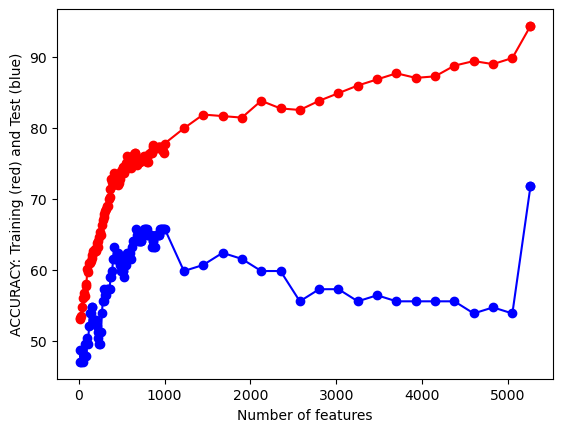

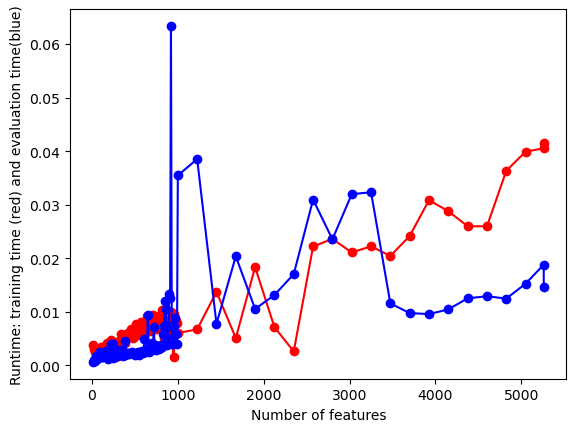

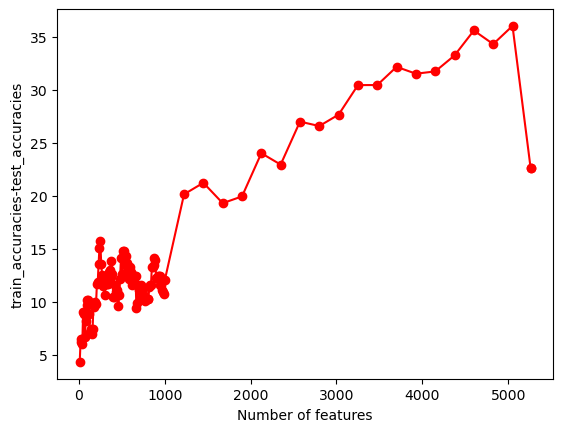

In [69]:
plot_results()

1. The graph shows the relationship between the model's performance and the number of features used. We can see that thought the training accuracy is higher when the feature is more, the testing accuracy is becoming lower, indicating an overfitting. Until after the 5000 features was add then both the training and testing accuracy start to grow.

2. It shows the number of feature and the corrsponded time costing. We can see it is highly random when the feature number was small, but after 4000 features, the time cost starts to goes up relatively more stable.

3. This shows the number of feature and the corrseponded difference between training and testing accuracy. The difference keeps going up until reaching 5000 features, then it starts to go down, which align with the first graph.

In [70]:
x_var=np.var(x,axis=0)
print(np.min(x_var))
print(np.max(x_var))

0.005136849339823024
1152.3875625442513


## Feature Selection (Using Variance Threshold)

In [76]:
from sklearn.feature_selection import VarianceThreshold

# DEFINE GRID OF THRESHOLDS 
num_thresholds=30
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

#DOESN"T WORK WELL WITH EDGE VALUES 
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
initialize_arrays()
max_acc = 0
# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(x)
    print("THRESHOLD =",THRESHOLD, xtmp.shape[1])

    (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)
             
    #RECORD 
    if acc_test > max_acc:
        max_acc = acc_test
        x_best = xtmp
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)
    train_time.append(time_train)
    eval_time.append(time_eval)

THRESHOLD = 3.8592586744064166 75
THRESHOLD = 7.7133804994730095 40
THRESHOLD = 11.567502324539603 29
THRESHOLD = 15.421624149606197 24
THRESHOLD = 19.27574597467279 18
THRESHOLD = 23.129867799739383 17
THRESHOLD = 26.98398962480598 17
THRESHOLD = 30.83811144987257 17
THRESHOLD = 34.69223327493916 16
THRESHOLD = 38.546355100005755 14
THRESHOLD = 42.40047692507235 12
THRESHOLD = 46.25459875013894 10
THRESHOLD = 50.10872057520553 10
THRESHOLD = 53.96284240027213 10
THRESHOLD = 57.81696422533872 9
THRESHOLD = 61.671086050405314 9
THRESHOLD = 65.5252078754719 9
THRESHOLD = 69.3793297005385 9
THRESHOLD = 73.23345152560509 9
THRESHOLD = 77.08757335067169 9
THRESHOLD = 80.94169517573827 9
THRESHOLD = 84.79581700080487 9
THRESHOLD = 88.64993882587147 8
THRESHOLD = 92.50406065093806 7
THRESHOLD = 96.35818247600466 6
THRESHOLD = 100.21230430107124 6
THRESHOLD = 104.06642612613784 6
THRESHOLD = 107.92054795120444 6
THRESHOLD = 111.77466977627103 6
THRESHOLD = 115.62879160133762 6
THRESHOLD = 119.

In [79]:
max_acc

91.45299145299145

We can see the result from the variance threshold is better to the partial grid search. So we choose this as the final result.

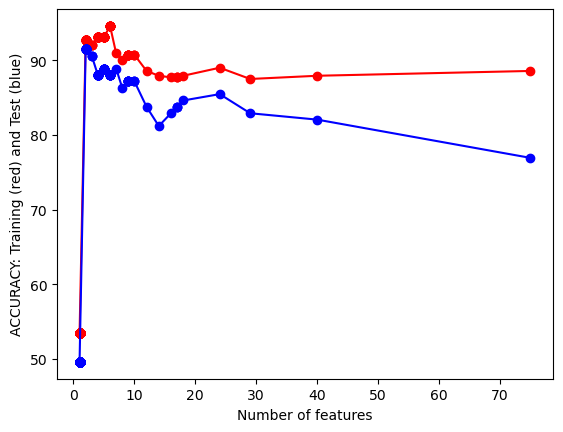

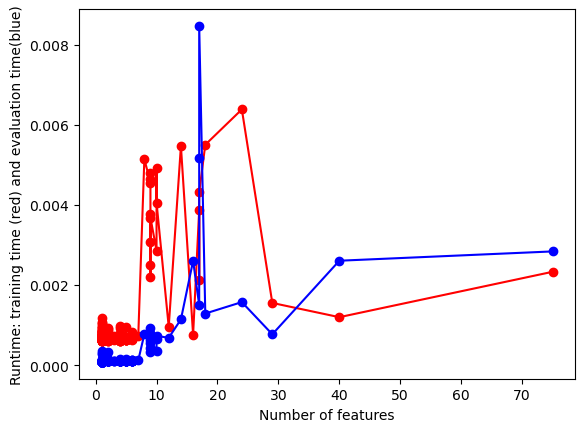

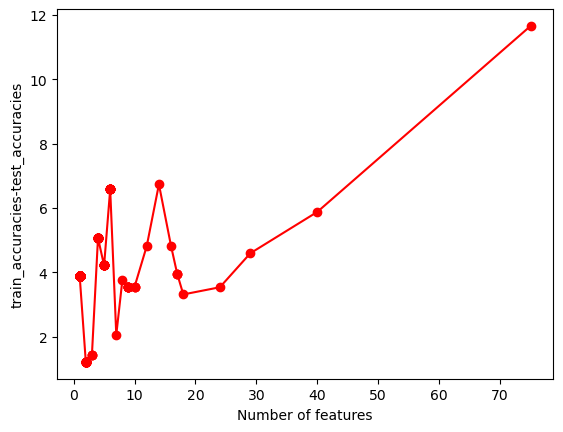

In [77]:
plot_results()

1. This graph speaks the same thing as the first graph of the last group. But notice the features number are dramtically downed. Which means a lot of features were at a very low variance or extremely high which got cutted off when cutting the edge value.

2. The second one shows the time cost with differnt amount of features, again, it was quite random when the feature number was small, but after 30 features, the time cost starts to goes relatively stable.

3. This shows when the number of feature goes up, the difference between training and testing accuracy goes bigger and bigger. Combine with the result from the first graph, we can see as the feature goes up the modle is becoming overfitting.

## Final Result

In [83]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import time

def generate_final_result(X, Y):


    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # class_prior=[prior_0,prior_1]
    # INITIALIZE MODEL 
    model = MultinomialNB()


    # TRAIN MODEL 
    model.fit(x_train,y_train)

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)

    f1 = f1_score(y_test, yp_test)

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100


    return acc_train,acc_test, f1, yp_test, y_test

In [84]:
acc_train,acc_test, f1, yp_test, y_test = generate_final_result(x_best, y)

In [85]:
acc_train

92.67241379310344

In [86]:
acc_test

91.45299145299145

We can see after feature engineering, the overfitting problem was solved. The accuracy is basically the same during training and testing.

In [91]:
f1

0.9166666666666667

A good F1 score, it is well above 0.75

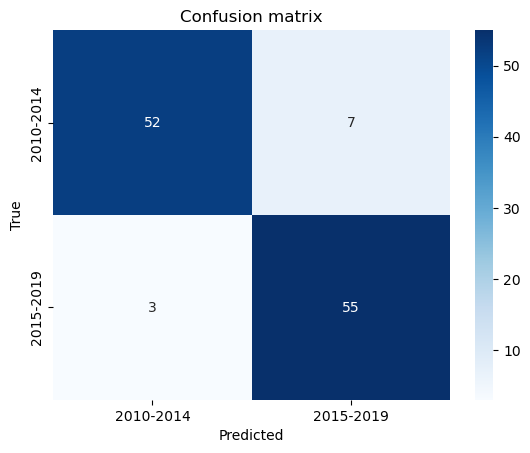

In [89]:
conf_matrix = metrics.confusion_matrix(y_test, yp_test, labels=[0, 1])

plt.title("Confusion matrix")
axis = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
axis.set_xticklabels(['2010-2014', '2015-2019'])
axis.set_yticklabels(['2010-2014', '2015-2019'])
axis.set(xlabel="Predicted", ylabel="True")
plt.show()

## Discussion

1. The modle was trained using the sklern inbulit MultinomialNB function. Using the fit method to train on the training dataset and predict method to test on the test set. 

2. The model has a both a good accuracy and a good F1. From the confusion matrix, we can see the the balance between the precision and recall is good as well. There are no sign of overfitting or underfitting.

3. The sign of overfitting and underfitting were discussed in the other use case of naive bayes classifier which was on the record data. For this, I will just discuss the conclusion, which is there are no sign of overfitting or underfitting in this model. The bias and variance are both low.

4. The project finds that predicting the valence mode for a song uisng it's lyric is highly doable by simple naive bayes. If there is a need for a report, this should be documented using like a R markdown or Jupyter notebook so the result is reproduceable. What should be reported include how the modle was trained, what is the dataset, the result and the limitation. 

## Conclusion

In conclusion, using a naive bayes on the lyrics data is a good idea. The model has a good accuarcy and a good F1 score, and from the confusion matrix we can see it perfome eqaully good on both classes. As a result, I think this model can be really useful in the real practice.